<a href="https://colab.research.google.com/github/jinwu99/Telco-Customer-Churn-Analysis/blob/main/Telco_customer_churn_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [2]:
cd MyDrive/My Drive/Colab Notebooks

/content/MyDrive/My Drive/Colab Notebooks


Data description :
* California 지역, 가상의 통신회사의 약 7000명 3분기 고객데이터
* 출처 : https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset/

# 분석 목적
* **고객의 서비스이용 패턴 탐색** 및 이탈율이 높은 이용패턴에 대한 **해결방안 제시**

## 분석 과정
1. 고객의 서비스이용 현황 파악
2. 고객의 정보를 바탕으로 군집화
3. 각 고객군집의 특성 파악 및 이탈율 높은 군집 분석

In [3]:
import pandas as pd

Telco = pd.read_csv('Telco_customer_churn.csv')
print(Telco.shape)
Telco.keys()

(7043, 33)


Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

* 분석에 앞서, 각 범주요인의 이름을 좀 더 구체화하자.
* 또한 Tenure과 Monthly Charges를 3분위수로 범주화하자.

In [4]:
Telco.loc[Telco['Churn Label']=='Yes', 'Churn Label'] = 'Churn_Yes'
Telco.loc[Telco['Churn Label']=='No', 'Churn Label'] = 'Churn_No'
Telco.loc[Telco['Senior Citizen']=='Yes', 'Senior Citizen'] = 'Senior'
Telco.loc[Telco['Senior Citizen']=='No', 'Senior Citizen'] = 'Not_Senior'
Telco.loc[Telco['Partner']=='Yes', 'Partner'] = 'w/Partner'
Telco.loc[Telco['Partner']=='No', 'Partner'] = 'No_Partner'
Telco.loc[Telco['Dependents']=='Yes', 'Dependents'] = 'w/Dependents'
Telco.loc[Telco['Dependents']=='No', 'Dependents'] = 'No_Dependents'
Telco = Telco.drop(columns=['Phone Service'])
Telco.loc[Telco['Multiple Lines']=='Yes', 'Multiple Lines'] = 'Multiple Lines'
Telco.loc[Telco['Multiple Lines']=='No', 'Multiple Lines'] = 'Single Line'
Telco.loc[Telco['Internet Service']=='No', 'Internet Service'] = 'No_Internet_Service'
Telco.loc[Telco['Online Security']=='Yes', 'Online Security'] = 'Online Security'
Telco.loc[Telco['Online Security']=='No', 'Online Security'] = 'No_Online Security'
Telco.loc[Telco['Online Backup']=='Yes', 'Online Backup'] = 'Online Backup'
Telco.loc[Telco['Online Backup']=='No', 'Online Backup'] = 'No_Online Backup'
Telco.loc[Telco['Device Protection']=='Yes', 'Device Protection'] = 'Device Protection'
Telco.loc[Telco['Device Protection']=='No', 'Device Protection'] = 'No_Device Protection'
Telco.loc[Telco['Tech Support']=='Yes', 'Tech Support'] = 'Tech Support'
Telco.loc[Telco['Tech Support']=='No', 'Tech Support'] = 'No_Tech Support'
Telco.loc[Telco['Streaming TV']=='Yes', 'Streaming TV'] = 'Streaming TV'
Telco.loc[Telco['Streaming TV']=='No', 'Streaming TV'] = 'No_Streaming TV'
Telco.loc[Telco['Streaming Movies']=='Yes', 'Streaming Movies'] = 'Streaming Movies'
Telco.loc[Telco['Streaming Movies']=='No', 'Streaming Movies'] = 'No_Streaming Movies'
Telco.loc[Telco['Paperless Billing']=='Yes', 'Paperless Billing'] = 'Paperless Billing'
Telco.loc[Telco['Paperless Billing']=='No', 'Paperless Billing'] = 'No_Paperless Billing'
Telco['Monthly Charges cat'] = pd.qcut(Telco['Monthly Charges'],q=3).cat.codes
Telco.loc[Telco['Monthly Charges cat']==0,'Monthly Charges cat'] = 'charge_low'
Telco.loc[Telco['Monthly Charges cat']==1,'Monthly Charges cat'] = 'charge_mid'
Telco.loc[Telco['Monthly Charges cat']==2,'Monthly Charges cat'] = 'charge_high'
Telco['Tenure Months cat'] = pd.qcut(Telco['Tenure Months'],q=3).cat.codes
Telco.loc[Telco['Tenure Months cat']==0,'Tenure Months cat'] = 'tenure_low'
Telco.loc[Telco['Tenure Months cat']==1,'Tenure Months cat'] = 'tenure_mid'
Telco.loc[Telco['Tenure Months cat']==2,'Tenure Months cat'] = 'tenure_high'

In [5]:
import plotly.io as pio
pio.renderers.default = "colab"

# 1.고객의 서비스이용 현황 파악
고객 데이터는 대략적으로 4가지 정보를 가진다 : \
1. 인구통계학적 정보
2. 이용하는 인터넷/전화 서비스 정보
3. 계약정보
4. 이탈이유

각 정보에 대한 고객의 현황을 살펴보자.

## 1.1. 인구통계학적 정보

In [6]:
import plotly.graph_objects as go

colors = ['lightgreen','salmon']
demo = ['Gender','Senior Citizen','Partner','Dependents']
churn = ['Churn_No','Churn_Yes']
showlegend = [True] + [False]*(len(demo)-1)
spacing = ['',' ','  ']

fig = go.Figure()

for d in range(len(demo)):
    grouped = Telco.groupby([demo[d], 'Churn Label']).size().unstack(fill_value=0).reset_index()
    for c in range(len(churn)):
        fig.add_trace(go.Bar(x=grouped[demo[d]], y=grouped[churn[c]], name=churn[c],
                             marker_color=colors[c], showlegend=showlegend[d]))
    if d < (len(demo)-1):
        fig.add_trace(go.Bar(x=[spacing[d]], y=[0], showlegend=False))



# Customize the plot layout
fig.update_layout(
    title="Customer Churn by Demographics",
    yaxis_title="Churn Count",
    legend_title="Churn Label",
    barmode='stack'
)

fig.update_layout(autosize=False,width=1200,height=500)
fig.show()

* 성별 비율이 비슷, 각 성별의 이탈율도 비슷하다.
* Senior(65세 이상)인 경우가 월등히 적되, 이탈율이 더 높은 편.
* 파트너 유무 비율이 비슷, 파트너가 있는 경우의 이탈율이 조금 더 높은 편.
* 부양가족이 있는 경우가 월등히 적되, 이탈율이 더 적은 편.

## 1.2. 이용하는 인터넷/전화 서비스 정보

In [7]:
colors = ['lightgreen','salmon']
service = ['Multiple Lines',
           'Internet Service','Online Security','Online Backup','Device Protection','Tech Support',
           'Streaming TV','Streaming Movies']
churn = ['Churn_No','Churn_Yes']
showlegend = [True] + [False]*(len(service)-1)
spacing = ['',' ','  ','   ','    ','     ','      ','       ','        ']

fig = go.Figure()

for d in range(len(service)):
    grouped = Telco.groupby([service[d], 'Churn Label']).size().unstack(fill_value=0).reset_index()
    if d > 1 :
        grouped = grouped.set_index(service[d]).drop(index='No internet service').reset_index()
    for c in range(len(churn)):
        fig.add_trace(go.Bar(x=grouped[service[d]], y=grouped[churn[c]], name=churn[c],
                             marker_color=colors[c], showlegend=showlegend[d]))
    if d < (len(service)-1):
        fig.add_trace(go.Bar(x=[spacing[d]], y=[0], showlegend=False))



# Customize the plot layout
fig.update_layout(
    title="Customer Churn by Service",
    yaxis_title="Churn Count",
    legend_title="Churn Label",
    barmode='stack'
)

fig.update_layout(autosize=False,width=1500,height=500)
fig.show()

* 전화회선은 단일이 제일 많고 이탈고객 수는 다중과 비슷.
* 인터넷회선 중 Fiber optic 이용자가 제일 많으면서 이탈율도 제일 높음.
* 보안, 백업, 보호, tech support 모두 이용자의 이탈율이 비이용자보다 적은 편.
* Streaming service에 대한 차이는 별로 없음.

## 1.3. 계약정보


In [8]:
colors = ['lightgreen','salmon']
service = ['Contract','Paperless Billing','Payment Method','Monthly Charges cat','Tenure Months cat']
churn = ['Churn_No','Churn_Yes']
showlegend = [True] + [False]*(len(service)-1)
spacing = ['',' ','  ','   ','    ','     ','      ','       ','        ']

fig = go.Figure()

for d in range(len(service)):
    grouped = Telco.groupby([service[d], 'Churn Label']).size().unstack(fill_value=0).reset_index()
    for c in range(len(churn)):
        fig.add_trace(go.Bar(x=grouped[service[d]], y=grouped[churn[c]], name=churn[c],
                             marker_color=colors[c], showlegend=showlegend[d]))
    if d < (len(service)-1):
        fig.add_trace(go.Bar(x=[spacing[d]], y=[0], showlegend=False))



# Customize the plot layout
fig.update_layout(
    title="Customer Churn by Contract",
    yaxis_title="Churn Count",
    legend_title="Churn Label",
    barmode='stack'
)

fig.update_layout(autosize=False,width=1500,height=500)
fig.show()

* 월계약이 가장 많으면서 이탈율도 가장 높음.
* Paperless Billing이 더 많으면서 이탈율도 더 높음.
* Electronic check가 가장 많으면서 이탈율도 가장 높음.
* 월마다 내는 비용이 높을수록 이탈율도 늘어나는 추세.
* 반면 Tenure은 길어질수록 이탈율이 줄어드는 추세.

## 1.4. 핵심 요약
1. 젊은 사람의 비중이 높지만, 고령자의 이탈율이 더 높다.
2. 부양가족이 있는 경우가 적지만, 이탈율 또한 매우 적다.
3. 인터넷 회선 중 Fiber optic의 이용자 수와 이탈율 모두 제일 높음.
4. 인터넷 부가서비스를 이용하는 경우 이탈율이 더 적음.
5. 계약방법 중 월계약이 가장 많으면서 이탈율도 가장 큼.
6. 월마다 내는 비용이 높을수록 이탈율이 늘어나지만, Tenure가 길어질수록 이탈율이 줄어듬.

## 1.5. 한계점
단일 변수로만 이탈율을 비교하는 것은 다음과 같은 위험성을 가진다 :
1. Simpson's Paradox : A trend appears in several groups of data but disappears or reverses when the groups are combined.
    * 간단한 예로, A그룹의 고객 이탈율이 B그룹의 고객 이탈율보다 높게 나오지만, B그룹의 고객 수가 A그룹보다 월등히 많다면, 두 그룹 모두 합쳤을 때 전반적 이탈율이 작게 나오는 효과를 볼 수 있다. 혹은 그 반대 효과도 나올 수 있다.
        * 우리의 예상보다 고객의 패턴 종류가 다양하다면, Simpson's Paradox가 나올 여지가 더 커질 것이다.
    * 우리의 데이터에도 비슷한 질문들을 적용해볼 수 있다 : 월계약의 이탈율이 높다는 것은, 모든 고객에게 해당되는 이야기일까?
        * 특정 고객 군에게만 해당되는 이야기일까?
    * 고령자의 이탈율이 높은 이유가 - 각 고객그룹의 정보를 합쳤을 때 우연히 그렇게 보이는 것이 아닐까?
        * 각 고객 그룹의 고령자 비율이 항상 낮다면, 이탈이 일어날 때 마다 젊은 사람의 이탈율보다 고령자의 이탈율 증가가 더 클 수 밖에 없다.
2. 변수들 간 상관성 존재 가능성.
    * 특정 인구통계학적 특징을 가진 고객은 특정 서비스들을 연계하여 활용할 가능성이 있다.
        * 어떤 한 요인에서 이탈율이 높게 나와 그 요인에 자칫 손보면, 그 요인과 연관된 다른 요인들도 영향받아 더 안좋은 효과를 낳을 수 있다.
    * 그렇다면 다중변수 분석을 하면 되지 않을까?
        * 현재 18가지의 범주형 변수에 대해 가능한 고객의 종류는 2,672,922가지. 7000여명의 고객 수보다 월등히 많은 가짓수라서 쉽지 않다.

## 1.6. 해결방안
1. 다중변수 분석 용으로 로지스틱 회귀분석 가능.
    * 각 변수에 대한 이탈율을 변수들 간의 상관성을 보정한 상태로 구할 수 있다.
    * 그렇지만 이 역시 Simpson's Paradox 문제를 피하기 어렵다. 고객 그룹마다 특징이 상이할 수 있기 때문.
        * 또한 각 그룹의 특징도 알기 어렵다.
    * 이에 대응하기 위해, 고객 그룹이 어떻게 나뉘는지 알고 있다는 전제하에, 각 그룹에 대해 로지스틱 회귀분석 하거나 모든 고객 데이터에 대해 로지스틱 혼합 모형을 사용해볼 수 있다.
        * 문제는 고객 군집이 어떻게 나뉘는지 알 수 없는 상태이다.

2. 군집분석.
    * 고객의 인구통계학 정보와 서비스사용 등 정보를 바탕으로 군집화하여 그룹으로 나눌 수 있다.
        * 다중변수 분석 용으로도 용이할 뿐더러, 앞서 언급하였듯 로지스틱 회귀분석의 연장선으로도 활용 가능하다.

# 2.고객의 정보를 바탕으로 군집화
군집분석은 크게 두 가지로 나눌 수 있다.

1. Distance-based clustering:  말 그대로 데이터 간의 dissimilarity를 먼저 측정하고 클러스터링 방법을 적용시키는 방법들을 말한다.
    * 다음 4가지를 결정해야 한다.
        1. 어떤 변수들을 클러스터링에 활용할 것인가?
        2. 어떤 distance metric을 활용할 것인가?
        3. 어떤 철학,Criterion의 클러스터링 방법을 활용할 것인가?
        4. 클러스터링 이후, 각 군집과 변수들간의 연관성은 어떻게 측정할 것인가?
    * 인구통계학 정보와 서비스이용 정보, 그리고 계약정보 모두 활용한다면 총 18가지의 범주형 변수를 고려하게 된다. 또한 범주형인 점을 고려하여 데이터간의 거리를 재기 위해 Simple matching이나 Gower distance 등을 활용할 수 있을 것이다.
        * 이에 따라 K-modes/median, hierarchical clustering 등 다양하게 적용할 수 있다는 점에서 꽤나 flexible하다.
    * 클러스터링 이후, 각 군집의 특징을 설명하기 위해 변수들과의 연관성도 측정해야한다. 클러스터 라벨도 범주형 변수로 취급한다면, Chi-square distance나 Simple matching 등 이 또한 다양한 방법들을 쓸 수 있을 것이다.
    <!-- * 그러나 거리 기반 클러스터링은 차원의 저주 문제가 있을 수 있다는 것. -->
        <!-- * 일차원에서 거리가 2cm였던 물체가 10차원에서는 거리가 무려 약 1km가 되어버리는 현상으로 볼 수 있다.  -->
        <!-- * 사실 Distance metric을 어떤 것 쓰냐 따라 차원의 저주 문제에 덜 민감할 수 있고, 또한 텍스트나 이미지와 같이 low dimension space에 워낙에 clustered되있는 데이터의 경우에도 덜 민감할 수 있다. 하지만 어디까지나 그럴 수 있다는 가능성의 얘기이다. -->


2. Model-based clustering: 데이터가 어떤 분포/방정식으로부터 생성되었을 것이라는 가정을 가지는 클러스터링 방법들을 말한다.
    * 범주형 변수들을 바탕으로 군집화하는 대표적인 방법은 Latent Class Analysis(LCA)로써, 다음과 같은 분포 가정을 가진다.
    \begin{align}
        (Z_1,...,Z_K) &\sim Multinomial(\phi_1,...,\phi_K), & \phi_k = P(Z_k=1) \\
        (X_1,...,X_J)|Z_k=1 &\sim Multinomial(\theta_{k,1},...,\theta_{k,J}), & \theta_{k,j} = P(X_j|Z_k=1) \\
        P(X_1,...,X_J) &= \sum_{k=1}^K P(Z_k=1)P(X_1,...,X_J|Z_k=1) \\
        &= \sum_{k=1}^K P(Z_k=1) \prod_{j=1}^J P(X_j|Z_k=1)
    \end{align}
    * 각 범주요인이 클러스터에 속할 확률을 가진다는 점에서 해석이 용이해진다 - 어떤 고객 군집이 확률적으로 어떤 서비스들을 많이 사용하는 편인지 등의 해석이 가능한 것이다.

* Distance-based clustering(DBC) VS Model-based clustering(MBC)
    * DBC는 MBC보다 다양한 방법으로 클러스터링할 수 있다.
        * 최선의 방법을 찾기 어려울 수 있다. 아무래도 '해석력' 기준에 맞추어 다양한 클러스터링 방법을 시도할텐데, '해석력'을 위한 변수들과의 연관성도 측정 또한 다양한 방법이 있기 때문에 문제가 복잡하다.
    * 반면 MBC는 분포가정으로 인해 해석적인데다, LCA의 한해 거리기반 클러스터링보다 차원의 저주 문제에 자유로운 편(LCA의 알고리즘에 데이터간 거리측정하는 식이 없다, 가우시안 혼합 모형은 제외).

* 따라서 LCA를 사용하기로 택하였다.
    

In [9]:
df_cat = Telco[['Gender', 'Senior Citizen', 'Partner', 'Dependents',
                'Multiple Lines', 'Internet Service',
                'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
                'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
                'Payment Method', 'Monthly Charges cat','Tenure Months cat', 'Churn Label']]

In [10]:
%%capture
!pip install stepmix

In [11]:
%%capture
from stepmix.stepmix import StepMix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

category_mappings = {}
for col in df_cat.columns:
    label_encoder = LabelEncoder()
    df_cat[col] =  label_encoder.fit_transform(df_cat[col])
    category_mappings[col] = dict(zip(label_encoder.classes_,
                                      label_encoder.transform(label_encoder.classes_)))

## 2.1. 최적의 클러스터 갯수
* BIC와 같은 지표로 최적의 클러스터 갯수를 정할 수 있다.
* 하지만 LCA 추정하는 알고리즘은 클러스터 갯수가 많을 수록 local optima에 취약하며, 많은 수의 클러스터 갯수를 최적이라고 진단하는 경향성을 가진다.
    * 따라서 고려하려는 클러스터 갯수 범위를 어느 정도 제한하는 것이 좋다.
* 최소한 하나의 클러스터에 평균적으로 700명은 존재한다는 가정을 한다면 - 클러스터 갯수 후보로 3개부터 10개까지 고려할 수 있다.

<ipython-input-19-8768144df0a0>:11: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



<Axes: xlabel='param_n_components', ylabel='bic'>

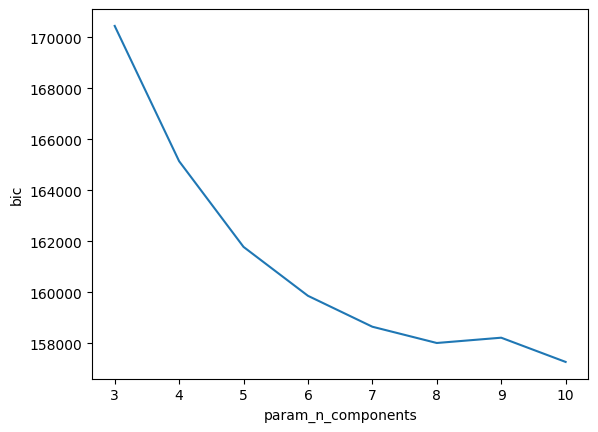

In [19]:
%%capture
k_candidates = range(3,11,1)
results = dict(param_n_components=[], aic=[], bic=[])
for k in k_candidates:
    model = StepMix(n_components=k, measurement="categorical", random_state=99)
    model.fit(df_cat)
    results['param_n_components'].append(k)
    results['aic'].append(model.aic(df_cat))
    results['bic'].append(model.bic(df_cat))

sns.lineplot(data=results, x='param_n_components', y='bic', palette='Dark2')

* BIC는 낮을 수록 좋기 때문에, 8개가 최적의 클러스터 갯수가 된다. 이제 각 클러스터의 고객수와 Churn rate을 확인해보자.

In [13]:
%%capture
num_cluster = 8
model = StepMix(n_components=num_cluster, measurement="categorical", random_state=99)
model.fit(df_cat)
df_cat['cluster'] = model.predict(df_cat)

In [14]:
cluster_counts = pd.DataFrame(df_cat['cluster'].value_counts().reset_index()).rename(columns={'index':'cluster', 'cluster':'counts'})
cluster_churn_counts = df_cat.groupby(['cluster','Churn Label']).size().unstack()
cluster_churn_rate = (cluster_churn_counts[1]/cluster_churn_counts.sum(axis=1)).reset_index().rename(columns={0:'Churn rate'})
cluster_churn = pd.merge(cluster_counts,cluster_churn_rate,left_on='cluster',right_on='cluster')
cluster_churn['cluster'] += 1
cluster_churn

,cluster,counts,Churn rate
0,3,1296,0.551698
1,6,1051,0.080875
2,7,894,0.586130
3,2,845,0.031953
4,5,829,0.008444
5,4,733,0.200546
6,8,698,0.369628
7,1,697,0.152080


* 각 클러스터의 고객수는 약 700명에서 1300명의 범위를 가진다.
* cluster 3, 7에서 이탈율이 50%를 넘긴다.
* 각 클러스터의 특징을 위해 LCA 결과를 radar chart으로 확인해보자.

In [15]:
mm = model.get_mm_df().round(2)
mm.index = [levels[2] for levels in mm.index]

new_cat_map = {}
for col in df_cat:
    if col=='cluster' : continue
    for idx, (key, val) in enumerate(category_mappings[col].items()) :
        new_cat_map[col + '_' + str(val)] = key

mm = mm.rename(index=new_cat_map)

In [16]:
# 각 범주요인의 글자 길이를 줄이기 위함.
mm.index = ['No Churn','Churn','Monthly','1yr','2yr',
            'No Dep','Dependents','Protect',
            'No int','No protect','Female','Male','DSL',
            'Fiber optic','No int','High fee','Low fee',
            'Mid fee','Multiple','No phone','Single',
            'No int','No onl bck','Backup',
            'No int','No onl sec','Security',
            'No ppb','PaperX Bill','No_part','Partner',
            'Bank','Credit card',
            'Electronic','Mailed','No senior','Senior',
            'No int','No stream mv','Stream MV',
            'No int','No stream tv','Stream TV',
            'No int','No tech','Tech Sup','High tenure',
            'Low tenure','Mid tenure']

In [17]:
# State of the contract
# state_label = ['Churn_Yes','Month-to-month','One year','Two year',
#                'charge_high','charge_mid','charge_low',
#                'tenure_high','tenure_mid','tenure_low']
state_label = ['Churn','Monthly','1yr','2yr',
               'High fee','Mid fee','Low fee',
               'High tenure','Mid tenure','Low tenure']
# Demographics
# demo_label = ['w/Dependents','w/Partner','Female','Male','Senior']
demo_label = ['Dependents','Partner','Female','Male','Senior']
# Billing method
# bill_label = ['Paperless Billing','Bank transfer (automatic)','Credit card (automatic)',
#               'Electronic check','Mailed check']
bill_label = ['PaperX Bill','Bank','Credit card',
              'Electronic','Mailed']
# Use Additiona; service?
# service_label = ['Multiple Lines','Single Line','DSL','Fiber optic',
#                  'Device Protection','Online Backup','Online Security',
#                  'Streaming Movies','Streaming TV','Tech Support']
service_label = ['Multiple','Single','DSL','Fiber optic',
                 'Protect','Backup','Security',
                 'Stream MV','Stream TV','Tech Sup']

label_list = [state_label,demo_label,bill_label,service_label]
id_vars_list = ['Contract_Status','Demographics','Billing','Service']

rename_col_list = []
for j in range(len(label_list)):
    rename_col = {}
    rename_col['index'] = id_vars_list[j]
    for k in range(num_cluster):
        rename_col[k] = 'cluster_' + str(k+1)
    rename_col_list.append(rename_col)

lca_list = [mm.loc[labels,:].reset_index() for labels in label_list]
lca_list = [lca_list[j].rename(columns=rename_col_list[j]) for j in range(len(label_list))]
lca_long_list = [lca_list[j].melt(id_vars=id_vars_list[j], var_name='Cluster', value_name='Probability') for j in range(len(label_list))]

In [18]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def Radar_SubPlot_for_Clusters(j,fig,row,col,show):
    colors = px.colors.qualitative.Set2
    for k in range(num_cluster):
        r = lca_long_list[j].loc[lca_long_list[j]['Cluster']=='cluster_'+str(k+1), 'Probability'].tolist()
        theta = lca_long_list[j].loc[lca_long_list[j]['Cluster']=='cluster_'+str(k+1), id_vars_list[j]].tolist()
        fig.add_trace(go.Scatterpolar(
            r=r,
            theta=theta,
            fill='toself',
            line_color=colors[k],
            opacity=0.8,
            name='Cluster '+str(k+1),
            showlegend=show,
        ),row=row, col=col)
        if row==8:
            row=1; col+=1
        else:
            row+=1
    return(fig,col)

def Radar_Plot_for_Clusters():
    fig = make_subplots(rows=8, cols=4,
                        specs=[[{'type': 'polar'}]*4]*8)
    show_legend = [True] + [False]*3
    row = col = 1
    for j in range(4):
        fig, col = Radar_SubPlot_for_Clusters(j,fig,row,col,show_legend[j])
    fig.update_polars(radialaxis=dict(range=[0, 1]))
    return(fig)

In [20]:
fig = Radar_Plot_for_Clusters()
fig.update_layout(autosize=False,width=1300,height=1500)
fig.show()

* Radar모양으로 클러스터간 구분이 쉽고 특징도 알기 쉽다.
* 하지만 클러스터가 많은 만큼 여전히 한눈에 파악하기 어렵다. Heatmap으로 다시 나타내보자.

In [21]:
import numpy as np

reorder_cluster = [5,1,2,6,3,7,4,0]
mm = mm[reorder_cluster]

label_list = [['Churn'],
              ['Multiple','Single'],
              ['DSL','Fiber optic'],
              ['Protect'],
              ['Backup'],
              ['Security'],
              ['Stream MV'],
              ['Stream TV'],
              ['Tech Sup'],
              ['High fee','Mid fee','Low fee'],
              ['High tenure','Mid tenure','Low tenure'],
              ['Monthly','1yr','2yr'],
              ['Female','Male'],
              ['Dependents'],
              ['Partner'],
              ['Senior'],
              ['Bank','Credit card','Electronic','Mailed'],
              ['PaperX Bill']]
x_axis = ['Churn','Phone','Internet','Protect','Backup','Security','Stream MV','Stream TV','Tech Sup','Charge','Tenure','Contract','Gender','Depend','Partner','Senior','Payment','PaperX Bill']
x_axis = ['<b>'+x+'</b>' for x in x_axis]
df_list = [mm.loc[label,:] for label in label_list]
df_list = [df.rename(columns=rename_col_list[0]) for df in df_list]

most_cat_list = np.array([[[label_list[j][np.argmax(df_list[j][col])]] for col in df_list[j].columns] for j in range(len(df_list))])
most_prob_list = np.array([[[df_list[j][col][np.argmax(df_list[j][col])]] for col in df_list[j].columns] for j in range(len(df_list))])

show_threshold = [1/2] + [1/3] + [1/2]*7 + [1/3]*3 + [1/2]*4 + [1/4] + [1/2]
for j in range(len(df_list)): most_cat_list[j][most_prob_list[j] < show_threshold[j]] = ''

most_cat = most_cat_list[0]
most_prob = most_prob_list[0]
for i in range(1,len(most_cat_list),1):
    most_cat = np.concatenate([most_cat,most_cat_list[i]],axis=1).tolist()
    most_prob = np.concatenate([most_prob,most_prob_list[i]],axis=1).tolist()

In [22]:
import plotly.graph_objects as go

cluster_name = ['<b>'+'Cluster '+str(k+1)+'</b>' for k in reorder_cluster]

fig = go.Figure(data=go.Heatmap(
    x=x_axis,
    y=cluster_name,
    z=most_prob,
    text=most_cat,
    texttemplate="%{text}",
    colorscale='RdBu',
    textfont={"size":13,"family":'Ariel'},
    zmin=0, zmax=1
))

fig.update_layout(
    title='Most Probable Category Heatmap',
    xaxis_title='',
    yaxis_title='',
)

fig.update_xaxes(side="top",tickfont_size=13,tickfont_family='Ariel')
fig.update_yaxes(tickfont_size=13,tickfont_family='Ariel')
fig.update_layout(autosize=False,width=1500,height=500)
fig.show()

* 각 범주형 변수에서 확률이 가장 큰 범주요인만 색상와 글씨를 표시하였다.
    * 예를 들어, Payment에서 Electronic의 확률이 0.3으로 가장 크다면 그것만 표시하였다.
* 만약 범주요인 중 'No..'라는 글자를 가진 경우 시각화에 제외하였다.

위의 8개의 클러스터를 대략 4개로도 묶어 볼 수 있다.
1. Cluster 1, Cluster 5 : Single 전화서비스만 이용하는 고객군.
    * Cluster 5가 tenure이 더 길고 계약기간도 길며, Partner가 존재하는 경향이 더 크다.
2. Cluster 8, Cluster 4 : Single 전화서비스와 DSL 인터넷을 월계약으로 이용하는 고객군.
    * Cluster 4가 Tenure이 더 길고  Single 전화서비스 사용 경향이 더 크다.
3. Cluster 7, Cluster 3 : Fiber optic 인터넷을 월계약으로 이용하는데 이탈율이 50% 이상인 위험고객군.
    * Cluster 7은 Multiple 전화서비스에다 Streaming 서비스도 이용하는 고소비 고객층.
4. Cluster 2, Cluster 6 : 인터넷 부가서비스 두루두루 이용하면서 긴 계약기간에 tenure도 가장 긴 VIP고객군.
    * Cluster 2가 상대적으로 전화서비스 이용안하고 DSL 인터넷 사용하기 때문에, Cluster 6로 유입시키는 전략을 짜야한다.

In [27]:
df_cat_reg = df_cat
df_cat_reg_list = [df_cat_reg[df_cat_reg['cluster']==k].reset_index(drop=True) for k in range(num_cluster)]
for k in range(num_cluster):
    df_cat_reg_list[k].columns = df_cat_reg_list[k].columns.str.replace(" ","_")

In [28]:
cluster_consider = [2,6]

model_formula = "Churn_Label ~ "
model_formula_list = [model_formula for k in cluster_consider]
covariate_drop_list = []
covariate_drop_list.append(['Internet_Service','Dependents'])
covariate_drop_list.append(['Internet_Service','Online_Security','Streaming_TV','Streaming_Movies','Tech_Support','Dependents'])

j = 0
for k in cluster_consider:
    for col in df_cat_reg_list[k].columns:
        if col not in covariate_drop_list[j]+['Churn_Label','cluster']:
            model_formula_list[j] += 'C(' + col + ')'
            if col != 'Tenure_Months_cat':
                model_formula_list[j] += ' + '
    j+=1

In [29]:
import statsmodels.formula.api as smf

model_list = []
cluster_consider = [2,6]
for j in range(2):
    print(j)
    model_list.append(smf.logit(model_formula_list[j], data=df_cat_reg_list[cluster_consider[j]]).fit())

0
Optimization terminated successfully.
         Current function value: 0.627313
         Iterations 5
1
         Current function value: 0.628627
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [30]:
model_list[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Churn_Label   No. Observations:                 1296
Model:                          Logit   Df Residuals:                     1278
Method:                           MLE   Df Model:                           17
Date:                Wed, 01 Nov 2023   Pseudo R-squ.:                 0.08793
Time:                        05:15:45   Log-Likelihood:                -813.00
converged:                       True   LL-Null:                       -891.38
Covariance Type:            nonrobust   LLR p-value:                 1.153e-24
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.9178      0.327     -2.804      0.005      -1.559      -0.276
C(Gender)[T.1]               -0.2329      0.119     -1.949      0.051      -0.467       0.001
C(Senior_Citizen)[T.1]        0.1332      0.131      1.017      0.309      -0.124       0.390
C(Partner)[T.1]               0.1143      0.124      0.923      0.356      -0.128       0.357
C(Multiple_Lines)[T.2]       -0.5522      0.138     -3.995      0.000      -0.823      -0.281
C(Online_Security)[T.2]      -0.2007      0.155     -1.293      0.196      -0.505       0.104
C(Online_Backup)[T.2]        -0.0642      0.125     -0.516      0.606      -0.308       0.180
C(Device_Protection)[T.2]    -0.0288      0.121     -0.237      0.813      -0.267       0.209
C(Tech_Support)[T.2]         -0.1957      0.147     -1.333      0.183      -0.484       0.092
C(Streaming_TV)[T.2]          0.4535      0.140      3.243      0.001       0.179       0.728
C(Streaming_Movies)[T.2]      0.4080      0.139      2.928      0.003       0.135       0.681
C(Contract)[T.1]             -0.0523      0.212     -0.247      0.805      -0.468       0.363
C(Paperless_Billing)[T.1]     0.3687      0.156      2.371      0.018       0.064       0.674
C(Payment_Method)[T.1]       -0.0644      0.222     -0.291      0.771      -0.499       0.370
C(Payment_Method)[T.2]        0.1313      0.169      0.777      0.437      -0.200       0.462
C(Payment_Method)[T.3]        0.0260      0.273      0.095      0.924      -0.509       0.561
C(Tenure_Months_cat)[T.1]     1.3536      0.210      6.454      0.000       0.943       1.765
C(Tenure_Months_cat)[T.2]     0.0470      0.174      0.270      0.787      -0.295       0.389
=============================================================================================
"""

유의한 변수 : Multiple Lines(-), Streaming_TV(+), Streaming_Movies(+), Paperless_Billing(+), Tenure_middle(+)
* Streaming 서비스와 Paperless_Bill은 이탈율 증가와 연관성이 있다.
* Tenure가 low인 경우보다 middle일때 이탈율 증가와 연관성이 커진다. 서비스를 이용하다가 불만이 더 커졌다고도 볼 수 있다.
    * 하지만 high인 경우 유의하지 않다.
* 전화서비스의 다중회선 서비스는 반대로 이탈율 감소와 연관성이 있다. 즉, 다중회선 서비스 자체는 큰 문제가 없을수도.

In [31]:
model_list[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Churn_Label   No. Observations:                  894
Model:                          Logit   Df Residuals:                      879
Method:                           MLE   Df Model:                           14
Date:                Wed, 01 Nov 2023   Pseudo R-squ.:                 0.07314
Time:                        05:15:51   Log-Likelihood:                -561.99
converged:                      False   LL-Null:                       -606.34
Covariance Type:            nonrobust   LLR p-value:                 6.673e-13
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.7106      0.476     -3.596      0.000      -2.643      -0.778
C(Gender)[T.1]               -0.0356      0.144     -0.247      0.805      -0.318       0.247
C(Senior_Citizen)[T.1]        0.0390      0.162      0.241      0.810      -0.278       0.357
C(Partner)[T.1]               0.0922      0.163      0.566      0.571      -0.227       0.412
C(Multiple_Lines)[T.2]       -0.1562      0.153     -1.019      0.308      -0.457       0.144
C(Online_Backup)[T.2]         0.0535      0.192      0.279      0.780      -0.322       0.429
C(Device_Protection)[T.2]     0.0787      0.216      0.365      0.715      -0.344       0.502
C(Contract)[T.1]             -0.5194      0.716     -0.726      0.468      -1.922       0.884
C(Contract)[T.2]             16.6263   3953.389      0.004      0.997   -7731.873    7765.126
C(Paperless_Billing)[T.1]     0.3759      0.168      2.242      0.025       0.047       0.705
C(Payment_Method)[T.1]       -0.4238      0.279     -1.521      0.128      -0.970       0.122
C(Payment_Method)[T.2]        0.2524      0.217      1.163      0.245      -0.173       0.678
C(Payment_Method)[T.3]       -0.2028      0.278     -0.729      0.466      -0.748       0.342
C(Tenure_Months_cat)[T.1]     2.0669      0.394      5.246      0.000       1.295       2.839
C(Tenure_Months_cat)[T.2]     1.1769      0.392      2.999      0.003       0.408       1.946
=============================================================================================
"""

유의한 변수 : Paperless_Billing(+), Tenure_Middle(+), Tenure_High(+)
* Paperless_Bill은 이탈율 증가와 연관성이 있다.
* Tenure이 middle인 경우와 high인 경우 모두 이탈율 증가와 연관성이 있다.